0.0 5.0
[0.0, 0.01, 0.0345, 0.1022, 0.3254, 1.0]
6.415637373923529
0.5 4.5
[0.0, 0.0119, 0.0439, 0.1451, 0.5185, 1.0]
7.199351928465618
1.0 4.0
[0.0, 0.0143, 0.0585, 0.2225, 0.7654, 1.0]
8.234172001038948
1.5 3.5
[0.0, 0.0177, 0.0843, 0.3724, 0.9071, 1.0]
9.040470874576627
2.0 3.0
[0.0, 0.02, 0.1168, 0.5523, 0.9457, 1.0]
9.452239797946378
2.5 2.5
[0.0, 0.0156, 0.1271, 0.626, 0.9457, 1.0]
9.496172398297587
3.0 2.0
[0.0, 0.0102, 0.1426, 0.6891, 0.9457, 1.0]
9.529441702988377
3.5 1.5
[0.0, 0.0043, 0.1663, 0.7388, 0.9457, 1.0]
9.535975523529574
4.0 1.0
None
4.5 0.5
None
5.0 0.0
None
{'Z': 9.535975523529574, 'zs': 3.5, 'zb': 1.5, 'bins_edges': [0.0, 0.0043, 0.1663, 0.7388, 0.9457, 1.0]}
[ 24 138  60  19   2]
[ 8.2618884  48.96131557 20.59943841  4.2891668   1.00271188]
[1.2736923e-02 1.1716876e+00 6.2367539e+00 9.1588097e+00 1.8162977e+01]


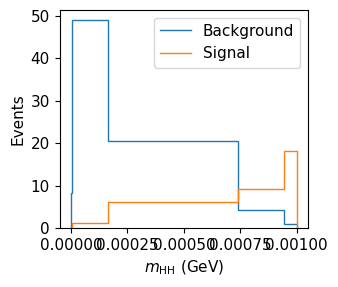

In [ ]:
import numpy as np
import h5py

import matplotlib.pyplot as plt


def CalculateSignificance(var, sig, bkg, bins_edges, w_CR):
    s_hist = np.histogram(
        sig[f"{var}_NOSYS.SR_xbb_2"],
        bins=bins_edges,
        weights=sig["weights_NOSYS.SR_xbb_2"],
    )[0]
    b_hist = (
        np.histogram(
            bkg[f"{var}_NOSYS.SR_xbb_1"],
            bins_edges,
        )[0]
        * w_CR
    )

    return (
        np.sum(
            [(2 * (s + b) * np.log(1 + s / b) - 2 * s) for s, b in zip(s_hist, b_hist)]
        )
    ) ** 0.5


def TransfoD(var, sig, bkg, zs, zb, nbins, w_CR, vbf_cut, eta_cut):
    bkg_min = 1
    if "bce" in var:
        start, stop, step = 0.0, 1.0, 1 / 10000
    elif var == "m_hh_5" or "m_hh":
        start, stop, step = 500.0e3, 5000.0e3, 200
    else:
        raise ValueError(f"Unsupported variable: {var}")
    list_edges = list(reversed(np.arange(start, stop + step, step)))

    signal_m_jj = sig[f"m_jj_NOSYS.SR_xbb_2"][:]
    signal_eta_jj = sig[f"eta_jj_NOSYS.SR_xbb_2"][:]
    bkg_SR_xbb_1_m_jj = bkg[f"m_jj_NOSYS.SR_xbb_1"][:]
    bkg_SR_xbb_1_eta_jj = bkg[f"eta_jj_NOSYS.SR_xbb_1"][:]
    bkg_VR_xbb_2_m_jj = bkg[f"m_jj_NOSYS.VR_xbb_2"][:]
    bkg_VR_xbb_2_eta_jj = bkg[f"eta_jj_NOSYS.VR_xbb_2"][:]
    bkg_VR_xbb_1_m_jj = bkg[f"m_jj_NOSYS.VR_xbb_1"][:]
    bkg_VR_xbb_1_eta_jj = bkg[f"eta_jj_NOSYS.VR_xbb_1"][:]

    sig_SR_xbb_2_weights = sig[f"weights_NOSYS.SR_xbb_2"][
        (signal_m_jj > vbf_cut) & (signal_eta_jj > eta_cut)
    ]
    sig_SR_xbb_2 = sig[f"{var}_NOSYS.SR_xbb_2"][
        (signal_m_jj > vbf_cut) & (signal_eta_jj > eta_cut)
    ]
    bkg_SR_xbb_1 = bkg[f"{var}_NOSYS.SR_xbb_1"][
        (bkg_SR_xbb_1_m_jj > vbf_cut) & (bkg_SR_xbb_1_eta_jj > eta_cut)
    ]
    bkg_VR_xbb_2 = bkg[f"{var}_NOSYS.VR_xbb_2"][
        (bkg_VR_xbb_2_m_jj > vbf_cut) & (bkg_VR_xbb_2_eta_jj > eta_cut)
    ]
    bkg_VR_xbb_1 = bkg[f"{var}_NOSYS.VR_xbb_1"][
        (bkg_VR_xbb_1_m_jj > vbf_cut) & (bkg_VR_xbb_1_eta_jj > eta_cut)
    ]
    all_bkg = len(bkg_SR_xbb_1) * w_CR

    all_sig = np.sum(sig_SR_xbb_2_weights)

    bins_edges = [stop]
    for lower_edge in list_edges:
        sig_frac = (
            np.sum(
                sig_SR_xbb_2_weights[
                    (sig_SR_xbb_2 >= lower_edge) & (sig_SR_xbb_2 < stop)
                ]
            )
            / all_sig
        )

        bkg_only = np.sum((bkg_SR_xbb_1 >= lower_edge) & (bkg_SR_xbb_1 < stop)) * w_CR
        bkg_frac = bkg_only / all_bkg
        Z = zs * sig_frac + zb * bkg_frac

        first_bin_bkg = (
            np.sum((bkg_SR_xbb_1 >= start) & (bkg_SR_xbb_1 < lower_edge)) * w_CR
        )
        # bkg_VR_xbb_2_sel = np.sum((bkg_VR_xbb_2 >= lower_edge) & (bkg_VR_xbb_2 < stop))
        # first_bin_bkg_VR_xbb_2_sel = np.sum(
        #     (bkg_VR_xbb_2 >= start) & (bkg_VR_xbb_2 < lower_edge)
        # )
        # bkg_VR = np.sum((bkg_VR_xbb_1 >= lower_edge) & (bkg_VR_xbb_1 < stop)) * w_CR
        # # bkg_unc_ratio = np.abs((bkg_VR - bkg_VR_xbb_2_sel) / bkg_VR)
        # first_bin_bkg_VR = (
        #     np.sum((bkg_VR_xbb_1 >= start) & (bkg_VR_xbb_1 < lower_edge)) * w_CR
        # )
        # first_bin_bkg_unc_ratio = np.abs(
        #     (first_bin_bkg_VR - first_bin_bkg_VR_xbb_2_sel) / first_bin_bkg_VR
        # )
        # print(all_sig)
        # print(bkg_only)
        # print(first_bin_bkg)
        if (
            Z > 1
            and bkg_only > bkg_min
            and first_bin_bkg > bkg_min
            # and bkg_VR_xbb_2_sel >= 1
            # and first_bin_bkg_VR_xbb_2_sel >= 1
            # and bkg_unc_ratio < 1
            # and first_bin_bkg_unc_ratio < 1
        ):

            # The float is for later saving as json
            bins_edges.append(float(np.round(lower_edge, 6)))
            stop = lower_edge
            if len(bins_edges) == nbins:
                if bins_edges[-1] > start:
                    bins_edges.append(start)

                return list(reversed(bins_edges))


def ZsZbGridSearch(var, sig, bkg, w_CR, vbf_cut, eta_cut, nbins):
    possible_values = np.arange(0, nbins + 1, 0.5)
    zs_best, zb_best, Z_best = 0, 0, 0
    bins_edges_best = []
    # possible_values = [2.5]
    for zs in possible_values:
        for zb in possible_values:
            if zs + zb != nbins:
                continue
            # if zs!=0 and zb!=5:
            # if zs != 5 and zb != 0:
            # if zs!=2.5 and zb!=2.5:
            #     continue
            bins_edges = TransfoD(var, sig, bkg, zs, zb, nbins, w_CR, vbf_cut, eta_cut)
            print(zs, zb)
            print(bins_edges)
            if bins_edges != None:
                Z = CalculateSignificance(var, sig, bkg, bins_edges, w_CR)
                print(Z)
            else:
                Z = 0
            if Z > Z_best:
                zs_best, zb_best, Z_best = zs, zb, Z
                bins_edges_best = bins_edges
    # if len(bins_edges_best) == nbins:
    #     print("Number of bins do not match. Trying again with nbins-1.")
    #     print(bins_edges_best)
    #     return ZsZbGridSearch(var, sig, bkg, nbins=nbins - 1)
    # else:
    # if bins_edges_best[1] < 0.01 and len(bins_edges_best) > 3:
    #     print("First bin too small, merging.")
    #     bins_edges_best = list(np.delete(bins_edges_best, 1))
    return {
        "Z": Z_best,
        "zs": zs_best,
        "zb": zb_best,
        "bins_edges": bins_edges_best,
    }


run2_file = "/lustre/fs22/group/atlas/freder/hh/run/dump/determine_asimov_cuts_bce_10k_5k/dump-run2.h5"
signal_file = "/lustre/fs22/group/atlas/freder/hh/run/dump/determine_asimov_cuts_bce_10k_5k/dump-l1cvv0cv1.h5"


var = "m_hh_5"
var = "tomatos_bce_5_10000_lr_0p0005"

with h5py.File(run2_file, "r") as bkg:
    with h5py.File(signal_file, "r") as sig:
        vbf_cut = 250e3
        eta_cut = 3

        # vbf_cut = 1012012.012012012
        # eta_cut = 4.864864864864865

        # vbf_cut = 1000e3
        # eta_cut = 4.5

        vbf_cut = 0.0
        eta_cut = 0.0

        bkg_CR_xbb_2 = np.sum(
            bkg[f"{var}_NOSYS.CR_xbb_2"][
                (bkg[f"m_jj_NOSYS.CR_xbb_2"][:] > vbf_cut)
                & (bkg[f"eta_jj_NOSYS.CR_xbb_2"][:] > eta_cut)
            ]
        )
        bkg_CR_xbb_1 = np.sum(
            bkg[f"{var}_NOSYS.CR_xbb_1"][
                (bkg[f"m_jj_NOSYS.CR_xbb_1"][:] > vbf_cut)
                & (bkg[f"eta_jj_NOSYS.CR_xbb_1"][:] > eta_cut)
            ]
        )
        w_CR = bkg_CR_xbb_2 / bkg_CR_xbb_1
        result = ZsZbGridSearch(var, sig, bkg, w_CR, vbf_cut, eta_cut, nbins=5)
        print(result)

        s_selection = (sig[f"m_jj_NOSYS.SR_xbb_2"][:] > vbf_cut) & (
            sig[f"eta_jj_NOSYS.SR_xbb_2"][:] > eta_cut
        )
        b_selection = (bkg[f"m_jj_NOSYS.SR_xbb_1"][:] > vbf_cut) & (
            bkg[f"eta_jj_NOSYS.SR_xbb_1"][:] > eta_cut
        )

        s_hist = np.histogram(
            sig[f"{var}_NOSYS.SR_xbb_2"][s_selection],
            bins=result["bins_edges"],
            weights=sig[f"weights_NOSYS.SR_xbb_2"][s_selection],
        )[0]
        b_hist = (
            np.histogram(
                bkg[f"{var}_NOSYS.SR_xbb_1"][b_selection],
                result["bins_edges"],
            )[0]
            * w_CR
        )
        print(
            np.histogram(
                bkg[f"{var}_NOSYS.VR_xbb_2"][
                    (bkg[f"m_jj_NOSYS.VR_xbb_2"][:] > vbf_cut)
                    & (bkg[f"eta_jj_NOSYS.VR_xbb_2"][:] > eta_cut)
                ],
                result["bins_edges"],
            )[0]
        )
        plt.rcParams.update({"font.size": 11})
        plt.figure(figsize=(3.5, 3))
        plt.stairs(b_hist, np.array(result["bins_edges"]) * 1e-3, label="Background")
        plt.stairs(s_hist, np.array(result["bins_edges"]) * 1e-3, label="Signal")
        plt.xlabel(r"$m_\mathrm{HH}$ (GeV)")
        plt.ylabel("Events")
        plt.legend()
        plt.tight_layout()
        plt.savefig(
            f"/lustre/fs22/group/atlas/freder/hh/run/plots/{var}_transfD_{vbf_cut}.pdf"
        )
        # plt.savefig(
        #     f"/lustre/fs22/group/atlas/freder/hh/run/plots/zs{result['zs']}_zb{result['zb']}_transfD.pdf"
        # )
        print(b_hist)
        print(s_hist)


# equal spaced binning on cut opt, does not yield cuts
# m_hh
# 0.0, same with VR protect
# {'Z': 4.337002185020626, 'zs': 4.5, 'zb': 0.5, 'bins_edges': [500000.0, 1038400.0, 1228200.0, 1468000.0, 1842800.0, 5000000.0]}
# [111  56  38  26  12]
# [33.50766485 19.95050662 13.16451922  8.90105225  5.22654379]
# [6.106028  6.770077  7.092408  7.2994175 7.473173 ]

# m_hh
# 250
# {'Z': 4.208035993433308, 'zs': 4.5, 'zb': 0.5, 'bins_edges': [500000.0, 1038200.0, 1226600.0, 1466800.0, 1840800.0, 5000000.0]}
# [35 13 12  8  4]
# [10.74752857  6.69027669  4.35246981  2.7566972   1.58779375]
# [5.279277  5.80624   6.1059923 6.3088894 6.4557095]

# m_hh
# 1000, 4.5
# {'Z': 4.174375299179622, 'zs': 0.0, 'zb': 5.0, 'bins_edges': [500000.0, 907200.0, 1023800.0, 1157800.0, 1407000.0, 5000000.0]}
# [8 5 1 3 2]
# [1.032762   1.04436607 1.04436607 1.04436607 1.04436607]
# [ 1.1052341  2.273458   2.9821196  5.026069  11.088821 ]

# bce best
# 0.0
# {'Z': 9.54734525092687, 'zs': 3.5, 'zb': 1.5, 'bins_edges': [0.0, 0.0062, 0.1651, 0.7219, 0.9387, 1.0]}
# [ 16 147  58  19   3]
# [ 7.63977107 49.4907532  21.43455204  4.50441828  1.00269585]
# [1.1451707e-02 1.1671799e+00 6.1343622e+00 9.1306686e+00 1.8299257e+01]

# bce 5k
# 0.0
# {'Z': 9.535975523529574, 'zs': 3.5, 'zb': 1.5, 'bins_edges': [0.0, 0.0043, 0.1663, 0.7388, 0.9457, 1.0]}
# [ 24 138  60  19   2]
# [ 8.2618884  48.96131557 20.59943841  4.2891668   1.00271188]
# [1.2736923e-02 1.1716876e+00 6.2367539e+00 9.1588097e+00 1.8162977e+01]

# bce 10k
# 0.0
# {'Z': 9.427935764935564, 'zs': 3.5, 'zb': 1.5, 'bins_edges': [0.0, 0.0044, 0.1875, 0.7726, 0.9575, 1.0]}
# [ 30 131  64  15   3]
# [10.84344081 47.97539148 18.85452628  4.09286736  1.00233486]
# [1.5607188e-02 1.3240108e+00 6.5364513e+00 9.1925945e+00 1.7674347e+01]

# bce best
# 250
# {'Z': 9.540553572853188, 'zs': 3.0, 'zb': 2.0, 'bins_edges': [0.0, 0.0253, 0.3116, 0.7388, 0.934, 1.0]}
# [ 2 36 17 14  3]
# [ 1.37376299 11.27693353  7.79723717  3.27589635  1.00012965]
# [ 0.01809774  0.8810858   3.6884353   7.341008   18.029226  ]